# **Dubai Estates Price Prediction** 
<p>in this project we will predict the price of <strong>Dubai</strong> estates based on studing the <strong>2022</strong> transactions.</p>

## Model Definition
### Modeling

Here we will chose ML models for our project as the following:

* With Linear regression.
* With Lasso regression.
* With KNN (K-Nearest Neighbors).
* With Random Trees for regression.
* With Neural Networks.

We will work with GridSearchCV for model selection.

Do some feature selection with SelectFwe, SelectKBest, CA.

CA: Corresponding anaylsis.

At first we will import the models and the needed libraries.

In [1]:
#Models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, InputLayer
from tensorflow.keras import layers

#Model Selection
from sklearn.model_selection import GridSearchCV, train_test_split

#preprocessing
from sklearn.feature_selection import SelectFwe, f_regression
from prince import  CA

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\ASUS\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Importing the data that came from the last stage (feature enginering). 

In [3]:
df = pd.read_csv('data/FeatureEngineeringDone.csv', index_col=[0])

Here we will split our data to **X** for **train** data and **y** for **test** Data

In [15]:
X = df.drop('MeterPrice', axis=1)
y = df.MeterPrice

Now we will start the model selection process by select the features which pass the filter below with the linear regression testing.

Significance value equal to 0.05.

In [16]:
selector = SelectFwe(score_func=f_regression, alpha=0.05)
new_data = selector.fit_transform(X,y)

mask = selector.get_support()
new_features = X.columns[mask]
temp = X[new_features]

In [20]:
for i in X.columns:
    if i not in temp.columns:
        print(i)

OtherTransactionType
Marina Mall
Dubai International Airport
OtherMall


In [21]:
X = X[new_features]
X.columns

Index(['Gifts', 'Mortgage', 'Sales', 'area1', 'area10', 'area2', 'area3',
       'area4', 'area5', 'area6', 'area7', 'area8', 'area9', '1 B/R', '2 B/R',
       '3 B/R', 'OtherRooms', 'Studio', '1', 'B', 'OtherParking', 'P',
       'Buj Khalifa Dubai Mall Metro Station', 'Business Bay Metro Station',
       'Creek Metro Station', 'Damac Properties', 'Dubai Internet City',
       'First Abu Dhabi Bank Metro Station', 'Jumeirah Lakes Towers',
       'Nakheel Metro Station', 'OtherMetro', 'Rashidiya Metro Station',
       'Sharaf Dg Metro Station', 'City Centre Mirdif', 'Dubai Mall',
       'Ibn-e-Battuta Mall', 'Mall of the Emirates', 'Burj Al Arab',
       'Burj Khalifa', 'Downtown Dubai', 'Motor City', 'OtherLandmark',
       'Sports City Swimming Academy'],
      dtype='object')

We select 43 features instead of 48.

Now we will try to figure out which features are most importance for prediction.

Starting with **RandomForestRegressor**

<AxesSubplot:>

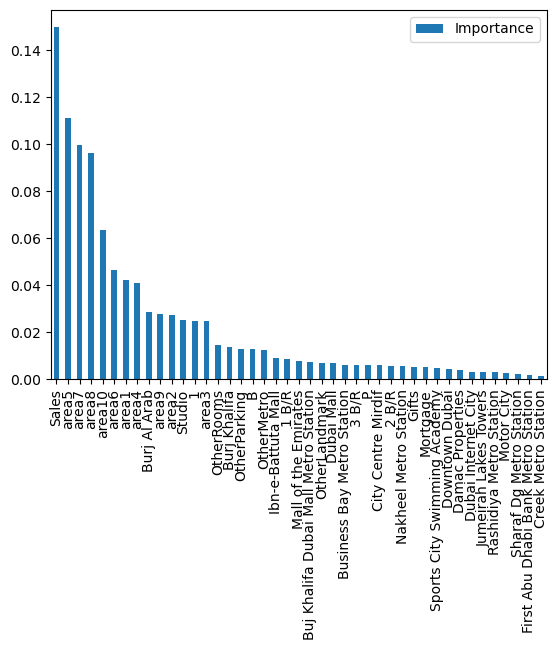

In [6]:
XRtr1 = X.copy()
rtr = RandomForestRegressor(n_estimators=100)

model = rtr.fit(XRtr1,y)
feat_importance = pd.DataFrame(model.feature_importances_, index=XRtr1.columns, columns=["Importance"])
feat_importance.sort_values(by="Importance", ascending=False, inplace=True)
feat_importance.plot(kind='bar')

We find that there are some features with low Importance, so we will apply **CA** (Corresponding Analysis) for dimensionality reduction, because the columns are categorical so this technic do the same as **PCA** (Principal Component Analysis), calculating eigenvalues based on contingency table.

In [7]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
ca = CA(
    n_components=28,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
ca = ca.fit(X)
caRes = ca.transform(xTrain)
caResY = ca.transform(xTest)

After do the CA we will plot how much each component explain the variance.

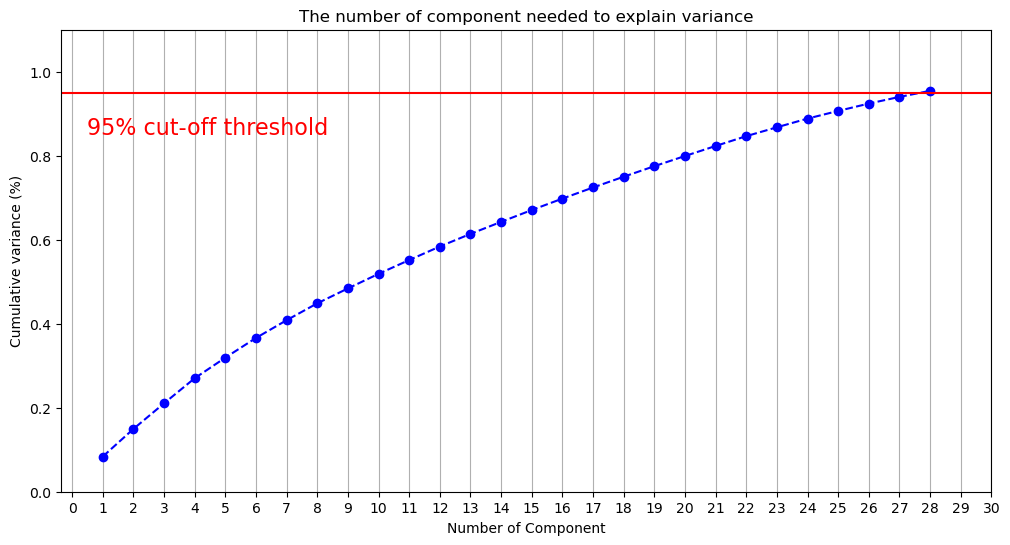

In [9]:
plt.rcParams['figure.figsize'] = (12,6)

fog, ax = plt.subplots()
xi = np.arange(1, 29, step=1)
yPlot = np.cumsum(ca.explained_inertia_)

plt.ylim(0.0, 1.1)
plt.plot(xi, yPlot, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Component')
plt.xticks(np.arange(0,31,step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of component needed to explain variance')

plt.axhline(y=0.95, color='red', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)

plt.grid(axis='x')
plt.show()

We find that the first 28 component explain 95% of the data variance.

In [12]:

caRes.join(yTrain).to_csv('data/TrainingDoneTrain.csv')
caResY.join(yTest).to_csv('data/TrainingDoneTest.csv')
pickle.dump(ca, open('models/CA.sav', 'wb'))

We will define models with multi parameters and pass them to **GridSearchCV** object.

In [19]:
# linear Regression
lr=LinearRegression()
lrGR = GridSearchCV(lr, n_jobs=-1,param_grid={'n_jobs' : [-1]}, verbose=0,scoring='r2')

# Lasso Regression
lassoParam = {'alpha':[0.0005, 0.001, 0.005],
              'selection' : ['cyclic', 'random']}
llr = Lasso()
lassoGS = GridSearchCV(llr, lassoParam, cv=10, n_jobs=-1, verbose=0, scoring='r2')

#KNN
knnParam = {'n_neighbors' : [20, 30, 50, 60, 80, 100],
            'weights' : ['distance']}
knn = KNeighborsRegressor(n_jobs=-1, p=1)
knnGS = GridSearchCV(knn, knnParam, cv=10, verbose=0, scoring='r2')

# RandomForestRegressor
rtrParam = {
    'n_estimators' : [100, 200, 300],
    'max_features' : ['auto', 'sqrt', 'log2'],
}
rtr = RandomForestRegressor()
rtrGS = GridSearchCV(rtr, param_grid=rtrParam, cv=10, n_jobs=-1, scoring='r2')

#XGboost
xgbParam = {'booster' : ['gbtree', 'gblinear'],
            'rta' : [0.1, 0.3, 0.5],
            'alpha' : [1, 0],
            'lambda' : [1, 0],
            'sampling_method' : ['uniform', 'gradient_based']}
xgboost = xgb.XGBRegressor(verbosity=0)
xgbGS = GridSearchCV(xgboost, xgbParam, cv = 10, n_jobs=-1, verbose=0, scoring='r2')

Now we will store thos models for the next stage.

In [20]:
pickle.dump(lrGR, open('models/linearRegression.sav', 'wb'))
pickle.dump(lassoGS, open('models/lassoRegression.sav', 'wb'))
pickle.dump(knnGS, open('models/KNN.sav', 'wb'))
pickle.dump(rtrGS, open('models/rtr.sav', 'wb'))
pickle.dump(xgbGS, open('models/XGboost.sav', 'wb'))

Next in Model_definition will be with Neural Networks.

Our neural network will be Sequential like the following:

<dl>
    <dt>Model 1:</dt>
    <dd>One hidden layer with 64 units.</dd>
    <dt>Model 2:</dt>
    <dd>Two hidden layers with 64 and 32 units.</dd>
    <dt>Model 3:</dt>
    <dd>Three hidden layers with 64, 32 and 16 units.</dd>
    <dt>Loss function:</dt>
    <dd>Mean Squared Error (MSE)</dd>
    <dt>Optimizer:</dt>
    <dd>adaptive estimation of first-order and second-order moments (Adam)</dd>
</dl>

In [15]:
NNModel = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(28, )),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

NNModel.compile(loss=keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(0.001), metrics=[keras.metrics.MeanSquaredError()])
NNModel.save('models/nn64')

NNModel = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(28, )),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='linear')
])

NNModel.compile(loss=keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(0.001), metrics=[keras.metrics.MeanSquaredError()])
NNModel.save('models/nn64-32')

NNModel = keras.Sequential([
    layers.Dense(28, activation='relu', input_shape=(28, )),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

NNModel.compile(loss=keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(0.001), metrics=[keras.metrics.MeanSquaredError()])
NNModel.save('models/nn64-32-16')

NNModel = keras.Sequential([
    layers.Dense(200, activation='relu', input_shape=(28, )),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

NNModel.compile(loss=keras.losses.MeanSquaredError(), optimizer=tf.optimizers.SGD(), metrics=[keras.metrics.MeanSquaredError()])
NNModel.summary()
NNModel.save('models/nn200')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 200)               5800      
                                                                 
 dropout_29 (Dropout)        (None, 200)               0         
                                                                 
 dense_43 (Dense)            (None, 1)                 201       
                                                                 
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models/nn200\assets


Now we finish model definition stage.